In [ ]:
! pip install transformers datasets

In [ ]:
! pip install fugashi ipadic

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

In [ ]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json
# jupyter notebookで動くように書き換え↓
# ! pip install matplotlib
# ! pip install japanize-matplotlib

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
rm: cannot remove '/root/.cache/matplotlib/fontlist-v310.json': No such file or directory


In [ ]:
!sudo apt-get install fonts-ipafont-gothic
!sudo fc-cache -fv
!rm /root/.cache/matplotlib/fontlist-v310.json

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype/ipafont-gothic: caching, new cache contents: 2 fonts, 0 dirs
/usr/share/fonts/opentype/ipafont-mincho: caching, new cache contents: 2 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 2 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/opentype: skipping, looped directory de

In [ ]:
! pip install japanize-matplotlib


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [ ]:
# if 'IPAGothic' not in plt.rcParams['font.family']:
#     plt.rcParams['font.family'] = 'MS Gothic'

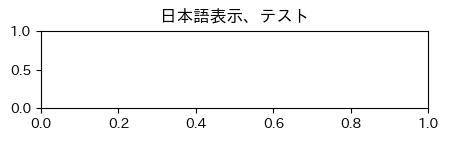

In [ ]:
# 動作確認
plt.figure(figsize=(5, 1))
plt.title('日本語表示、テスト')
plt.show()

In [ ]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）

! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

# question to ask
# tried to run the command through this cell, didn't work.
# installed wget, but couldn't execute the file
# manually moved the file to the system32 file of windows and ran the program through cmd (and worked??)

# fugashiがインストールできない
# -> mecab.hが認識されない -> 通常はincludeサブディレクトリにあるはずだが、代わりにsrcに入っている（そしてincludeは存在していない）
# -> mecabを再度インストール -> mecabのバージョンをチェックしたいmecab --versionが、エラー（'mecab' is not recognized as an internal or external command,
# operable program or batch file.）-> 環境変数にpathを追加 -> INCLUDE変数も追加 -> やっぱりmecab.hが認識されない
# mecabのビルド済みバイナリをインストール　pip install mecab-python-binary　pip install mecab-python3　pip install mecab-python3 --global-option="--with-cflags=-IC:\Users\minaa\OneDrive\TCA\mecab\mecab\mecab\src"
# fugashiを諦めます


--2024-01-09 08:56:21--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2024-01-09 08:56:22--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487235 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv.2’

wrime-ver1.tsv.2    100%[===================>]   9.05M  --.-KB/s    in 0.09s   

2024-01-09 08:56:22 (99.3 MB/s) - ‘wrime-ver1.tsv.2’ saved [9487235/9487235]



In [ ]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


In [ ]:
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
num_labels = len(emotion_names)
# objective emotion average (Avg. Readers_*) values are converted to list, defined as a new column
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# removing samples with less emotion intensities
# (max.readers_emotion_intensities must be 2 or more)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [ ]:
# divide into train and test data
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
# print('train :', len(df_train))
# print('test :', len(df_test))

In [ ]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#  (1) 使用するモデルをより簡素なものに
# checkpoint = 'distilbert-base-japanese'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
#  (2) モデルの一部の層を削減して軽量化
from transformers import AutoModel, AutoConfig

config = AutoConfig.from_pretrained(checkpoint, num_hidden_layers=6)  # 6層に変更
model = AutoModel.from_pretrained(checkpoint, config=config)

In [ ]:
#  (3)モデルのEmbedding層の次元を削減することで、パラメータ数を減らし、モデルを軽量化
from transformers import AutoModel, AutoConfig

config = AutoConfig.from_pretrained(checkpoint, hidden_size=252)  # 例えば256次元に変更->multiples of 12, 252 -> 事前学習済みモデルの重みとモデル構造のサイズが一致しない
model = AutoModel.from_pretrained(checkpoint, config=config, ignore_mismatched_sizes=True) #ignore_mismatched_sizes=Trueを追加->次元の不一致を無視してモデルを読み込む

Some weights of BertModel were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([32000, 768]) in the checkpoint and torch.Size([32000, 252]) in the model instantiated
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 768]) in the checkpoint and torch.Size([512, 252]) in the model instantiated
- bert.embeddings.token_type_embeddings.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([2, 252]) in the model instantiated
- bert.embeddings.LayerNorm.weight: found shape torch.Size([768]) in the checkpoint and torch.Size([252]) in the model instantiated
- bert.embeddings.LayerNorm.bias: found shape torch.Size([768]) in the checkpoint and torch.Size([252]) in the model instantiated
- bert.encoder.layer.0.attention.self.query.weight: found shape torch.Size([768, 768]) in the checkp

In [ ]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', return_tensors="pt")
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

<ipython-input-21-175910f6c859>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
! pip install transformers[torch]

In [ ]:
# # Transformers の Trainer を用いる
# # https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments

# # 訓練時の設定
# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     per_device_train_batch_size=8
#     num_train_epochs=1.0,
#     evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# # Trainerを生成
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_tokenized_dataset,
#     eval_dataset=test_tokenized_dataset,
#     compute_metrics=compute_metrics,
# )

# # 訓練を実行
# trainer.train()

In [ ]:
# "Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`"
# (1) バージョン確認->ある
! pip show accelerate

Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
# "Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`"
# (2) キャッシュをクリアしてから再度実行->同じエラー
! pip install --no-cache-dir transformers[torch]

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# AdamWオプティマイザの定義
optimizer = AdamW(model.parameters(), lr=2e-5)  # lrは学習率,これがデフォルト

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def tokenize_batch(batch):
    return tokenizer(batch['Sentence'], truncation=True, padding=True)

In [ ]:
#Trainer.__init__() got an unexpected keyword argument 'lr_scheduler' -> transformersが最新バージョンかチェック
! pip install transformers --upgrade


     36 # 訓練を実行
---> 37 trainer.train()

7 frames
/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py in torch_default_data_collator(features)
    134                 batch[k] = torch.tensor(np.stack([f[k] for f in features]))
    135             else:
--> 136                 batch[k] = torch.tensor([f[k] for f in features])
    137
    138     return batch

ValueError: expected sequence of length 112 at dim 1 (got 97)


このエラーは、torch_default_data_collator内のデータコレーションの過程で、シーケンスの次元が予想よりも短いものが含まれていることを示しています。特定のフィーチャが予想よりも短い場合、PyTorchのtorch.tensor()が期待する次元に達していない可能性があります。

エラーの原因を特定するために、以下の点を確認してみてください：

(1) train_tokenized_datasetおよびtest_tokenized_datasetの中の各サンプルのフィーチャの長さが一様であるかどうかを確認してください。データセット内で異なる次元のデータが混在している可能性があります。->トリミングを行う->同じエラー

(2) トークン化されたデータセットが正しく行われており、予期せぬデータが混入していないかを確認してください。異なるサンプルのフィーチャが予期せぬ次元である場合、データの前処理に問題があるかもしれません。->トークン数をそろえる->同じエラー

(3) トークン化されたデータセットがPyTorchテンソルに変換される際に、不適切なサイズのテンソルが生成されていないか確認してください。->トークン化されたデータセットをPyTorchテンソルに変換し、そのサイズを確認->問題なし

In [ ]:
# (1)
#データセット内の各サンプルのSentenceを同じ長さに調整する
# パディングを行うか、あるいはトリミングを行う
max_length = 50  # 調整後の最大長さ

# Sentenceを指定した長さにトリミングする関数
def trim_sentence(sample, tokenizer, max_length):
    # Sentenceをトークン化
    tokens = tokenizer(
        sample['Sentence'],
        max_length=max_length,
        truncation=True,
        padding='max_length'  # パディングもmax_lengthに合わせる
    )

    # トリミング後のトークンを元のフィーチャに反映
    sample['input_ids'] = tokens['input_ids'][:max_length]
    sample['attention_mask'] = tokens['attention_mask'][:max_length]

    return sample

# トリミングを適用
trimmed_train_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in train_tokenized_dataset]
trimmed_test_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in test_tokenized_dataset]


In [ ]:
# トリミング後のトークン数を表示
for sample in trimmed_train_tokenized_dataset[:5]:
    print(len(sample['input_ids']))

for sample in trimmed_test_tokenized_dataset[:5]:
    print(len(sample['input_ids']))


50
50
50
50
50
50
50
50
50
50


In [ ]:
# (2)
import random

# ランダムなサンプルを表示
for sample in random.sample(list(trimmed_train_tokenized_dataset), 5):
    print(sample)

{'Sentence': '吐瀉物が落ちている、TOKYO', 'readers_emotion_intensities': [0, 1, 0, 0, 0, 0, 2, 0], '__index_level_0__': 1440, 'input_ids': [2, 1, 410, 14, 3024, 16, 33, 6, 10713, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'Sentence': '夫、GWの事何も言わなくなったから断念したのかな。(性格上言えばムキになると思うので、私からは土曜からその話題を振ってない)', 'readers_emotion_intensities': [1, 0, 2, 0, 0, 0, 0, 0], '__index_level_0__': 536

In [ ]:
# トークンの数を表示
for sample in random.sample(list(trimmed_train_tokenized_dataset), 5):
    print(len(sample['input_ids']))


50
50
50
50
50


In [ ]:
# (3)

import torch

# トークン化されたデータセット（例としてtrimmed_datasetを使用）
# （trimmed_datasetは辞書のリストであると仮定）
tokenized_tensors = {
    'input_ids': torch.tensor([sample['input_ids'] for sample in trimmed_train_tokenized_dataset]),
    'attention_mask': torch.tensor([sample['attention_mask'] for sample in trimmed_train_tokenized_dataset]),
    # 他のトークン化された特徴も追加する
}

# 各テンソルのサイズを確認
for key, tensor in tokenized_tensors.items():
    print(f"{key} size: {tensor.size()}")


input_ids size: torch.Size([17104, 50])
attention_mask size: torch.Size([17104, 50])


各サンプルが同じ次元数の特徴を持っているか

データコレーターの処理で何かしらの不備が生じている->データコレーターに手動で調整を加えるか、または他のデータコレーターを検討する


In [ ]:
from transformers import get_linear_schedule_with_warmup

# トレーニング時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=7,
    num_train_epochs=0.9,
    evaluation_strategy="steps",
    eval_steps=200,
    lr_scheduler_type="linear",  # スケジューラのタイプを指定
)

# Trainerを生成（schedulerの設定はTrainerの前に行う）
# train_tokenized_dataset = train_dataset.map(tokenize_batch, batched=True)
# test_tokenized_dataset = test_dataset.map(tokenize_batch, batched=True)

# 学習率のスケジューラの設定
num_training_steps = len(train_tokenized_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)


In [ ]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)

        if labels is None:
            if "labels" not in inputs or inputs["labels"] is None:
                raise ValueError("Labels are missing or None in the inputs during training.")
            else:
                labels = inputs["labels"]

        # モデルのフォワードパス
        outputs = model(**inputs)

        # logitsから損失を計算
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)

        if return_outputs:
            return (loss, outputs)
        else:
            return loss.item() if hasattr(loss, "item") else loss


labelsがトレーニング中に欠落しているというエラーは、トレーニングデータセットにlabelsが正しく含まれていない可能性があります。以下の点を確認してください。

1 トレーニングデータセットにlabelsが正しく含まれているか確認してください。各サンプルに対してlabelsが与えられている必要があります。

2 トークナイザーを適切に適用しているか確認してください。トークン化されたデータセットにlabelsが適切に含まれていることが必要です。

3 CustomTrainerを初期化する際に、train_dataset引数にトレーニングデータセットを指定していますか？

例えば、トレーニングデータセットの各サンプルが辞書としてinput_idsとlabelsをキーとして持っている場合、以下のようなトレーニングデータセットを作成してCustomTrainerに渡すことが考えられます。

In [ ]:
#1
# トレーニングデータセットの最初の数サンプルを確認
for i in range(min(5, len(trimmed_train_tokenized_dataset))):
    sample = trimmed_train_tokenized_dataset[i]
    print(f"Sample {i + 1}:\n{sample}\n")


Sample 1:
{'Sentence': 'ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…', 'readers_emotion_intensities': [0, 2, 0, 0, 0, 0, 0, 0], '__index_level_0__': 0, 'input_ids': [2, 3937, 28517, 26099, 15, 16, 3318, 12272, 640, 8, 1131, 28479, 31, 40, 2949, 7, 12, 1549, 5602, 3215, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Sample 2:
{'Sentence': '今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡', 'readers_emotion_intensitie

In [ ]:
# 通常のTrainerと同様の引数を指定して、CustomTrainerを初期化する
custom_trainer = CustomTrainer(
    model=model,                        # トレーニングするモデル
    args=training_args,                  # トレーニングの設定
    train_dataset=trimmed_train_tokenized_dataset,  # トレーニングデータセット
    eval_dataset=trimmed_test_tokenized_dataset,    # 評価データセット
    compute_metrics=compute_metrics,     # メトリクスの計算関数
    data_collator=pad_collate,  # パディングを行うデータコレーターを指定
    optimizers=(optimizer, scheduler)    # カスタムTrainerにはoptimizerとschedulerをタプルで渡す
)

# 訓練を実行
custom_trainer.train()


ValueError: Labels are missing or None in the inputs during training.

In [ ]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [ ]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)


In [ ]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

In [ ]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

In [ ]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)


In [ ]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

In [ ]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)